# Requirements

In [1]:
import abc
from collections import defaultdict
import matplotlib.pyplot as plt
from operator import itemgetter
import random
%matplotlib inline

# Implementation

First we define a class to evolve the cellular autotomaton.  A runner is created for a specific rule, specified by a number between 0 and 255.  For instance, rule 47 would translate to:
* $000 \mapsto 1$
* $001 \mapsto 1$
* $010 \mapsto 1$
* $011 \mapsto 1$
* $100 \mapsto 0$
* $101 \mapsto 1$
* $110 \mapsto 0$
* $111 \mapsto 0$

In [2]:
class AutomatonRunner:
    
    def __init__(self, rule_nr):
        self._compute_rules(rule_nr)
        
    def _compute_rules(self, rule_nr):
        self._rules = []
        for _ in range(8):
            self._rules.append(rule_nr % 2)
            rule_nr //= 2
    
    def _apply_rule(self, environment):
        env_nr = 4*environment[0] + 2*environment[1] + environment[2]
        return self._rules[env_nr]
    
    def _make_environment(self, automaton, i):
        if 0 < i < len(automaton) - 1:
            return automaton[i - 1:i + 2]
        elif i == 0:
            return [automaton[-1]] + automaton[:2]
        elif i == len(automaton) - 1:
            return automaton[i - 1:] + [automaton[0]]
        
    def next_generation(self, automaton):
        ng_automaton = []
        for i in range(len(automaton)):
            environment = self._make_environment(automaton, i)
            ng_automaton.append(self._apply_rule(environment))
        return ng_automaton
                                
    def evolve(self, automaton, nr_generations):
        generations = [automaton]
        for _ in range(nr_generations):
            generations.append(self.next_generation(generations[-1]))
        return generations
    
    def __str__(self):
        auto_str = ''
        for i, result in enumerate(self._rules):
            auto_str += f'{i//4 % 2}{i//2 % 2}{i % 2} -> {result}\n'
        return auto_str

To verify the implementation, we check whether the rules have been created correctly.

In [3]:
runner = AutomatonRunner(47)

In [4]:
print(str(runner))

000 -> 1
001 -> 1
010 -> 1
011 -> 1
100 -> 0
101 -> 1
110 -> 0
111 -> 0



# Running an automaton

We create an automaton that is reandomly initialized.

In [5]:
automaton = random.choices((0, 1), k=10)

In [6]:
generations = runner.evolve(automaton, 10)

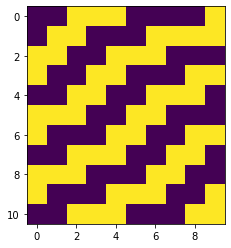

In [7]:
plt.imshow(generations)

# Exploring rules

In [8]:
nr_cols = 16
nr_generations = 80
figure, axes = plt.subplots(256//nr_cols, nr_cols, figsize=(100, 100))
automaton = random.choices((0, 1), k=20)
for rule_nr in range(256):
    row_nr = rule_nr//nr_cols
    col_nr = rule_nr % nr_cols
    runner = AutomatonRunner(rule_nr)
    generations = runner.evolve(automaton, nr_generations)
    axes[row_nr][col_nr].imshow(generations, aspect='auto')
    axes[row_nr][col_nr].set_title(str(rule_nr));
plt.tight_layout()

Rule 129 seems to be interesting.

In [9]:
runner = AutomatonRunner(129)

In [10]:
automaton = random.choices((0, 1), k=200)

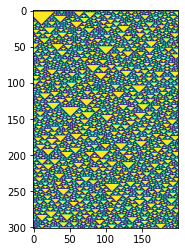

In [11]:
plt.imshow(runner.evolve(automaton, 300))

# Strategy

The current implementation keeps track of all generations of the automaton, but that may not be optimal. For many applications, the entire evolution of the automaton is not required, measures can be computed on a generation-by-generation basis.  Also, for some experiments, we can stop the evolution of the automaton after some criterium was met.  To accommodate for that, we rewrite the `evolve` method so that it can use a strategy.

In [12]:
class EvolutionStrategy(abc.ABC):
    
    @abc.abstractmethod
    def apply(self, automaton):
        ...

A strategy will be a class that is derived from this abstract base class.  It will have an `apply` method that takes the cuurent automaton as an argument.  If the evolution should continue, the `apply` method returns `True`, if not the `evolve` method will terminate.

We redefine the `AutomatonRunner` class to use a strategy while evolving an automaton.

In [13]:
class AutomatonRunner:
    
    def __init__(self, rule_nr):
        self._compute_rules(rule_nr)
        
    def _compute_rules(self, rule_nr):
        self._rules = []
        for _ in range(8):
            self._rules.append(rule_nr % 2)
            rule_nr //= 2
    
    def _apply_rule(self, environment):
        env_nr = 4*environment[0] + 2*environment[1] + environment[2]
        return self._rules[env_nr]
    
    def _make_environment(self, automaton, i):
        if 0 < i < len(automaton) - 1:
            return automaton[i - 1:i + 2]
        elif i == 0:
            return [automaton[-1]] + automaton[:2]
        elif i == len(automaton) - 1:
            return automaton[i - 1:] + [automaton[0]]
        
    def next_generation(self, automaton):
        ng_automaton = []
        for i in range(len(automaton)):
            environment = self._make_environment(automaton, i)
            ng_automaton.append(self._apply_rule(environment))
        return ng_automaton
                                
    def evolve(self, automaton, nr_generations, strategy):
        if not strategy.apply(automaton):
            return
        for _ in range(nr_generations):
            automaton = self.next_generation(automaton)
            if not strategy.apply(automaton):
                return
        return
    
    def __repr__(self):
        auto_str = ''
        for i, result in enumerate(self._rules):
            auto_str += f'{i//4 % 2}{i//2 % 2}{i % 2} -> {result}\n'
        return auto_str

In [14]:
runner = AutomatonRunner(129)

## Trivial strategy

As a somewhat trivial example, we can implement `PrintStrategy` that simply prints a textual representation of the automata at each stage of the evolution.  It derives for `EvolutionStrategy` and implements the `apply` method.

In [15]:
class PrintStrategy(EvolutionStrategy):
    
    def apply(self, automaton):
        print(''.join('X' if cell == 1 else ' ' for cell in automaton))
        return True

We can now run an automaton using the `PrintStrategy`.

In [16]:
runner = AutomatonRunner(47)

In [17]:
automaton = random.choices((0, 1), k=10)

In [18]:
generations = runner.evolve(automaton, 10, PrintStrategy())

  XXX X XX
 XX  XXXX 
XX  XX    
X  XX  XXX
  XX  XX  
XXX  XX  X
    XX  XX
 XXXX  XX 
XX    XX  
X  XXXX  X
  XX    XX


## Plot strategy

We can formulate a strategy that keeps track of all generations, similar to the original implementation of the `evolve` method, and that can plot the result when done.

In [19]:
class PlotStrategy(EvolutionStrategy):
    
    def __init__(self):
        self._generations = []
        
    @property
    def generations(self):
        return self._generations.copy()
    
    def plot(self):
        plt.imshow(self.generations)
        
    def apply(self, automaton):
        self._generations.append(automaton)
        return True

In [20]:
automaton = random.choices((0, 1), k=10)

In [21]:
plot_strategy = PlotStrategy()

In [22]:
runner.evolve(automaton, 10, plot_strategy)

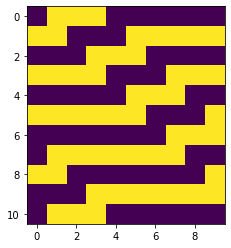

In [23]:
plot_strategy.plot()

## Sampling generations

For some measures we don't want to compute them for each individual generation, but, say, only every 10 generations.  This can easily be achieved by implementing the appropriate strategy.  The constructor of the strategy takes a measure as an argument.  A measure is simply a function that takes an automaton as its argument, and returns a value.  The constructor also takes the number of generations to skip as its second argument.  When it is done, you can get the sample, i.e., a list of tuples with the generation as the first element, and the value of the measure as the second.

In [24]:
class SampleStrategy(EvolutionStrategy):
    
    _current_generation: int = 0
    _delta_generations: int
    _sample: list = []
    
    def __init__(self, measure, delta_generations=1):
        self._measure = measure
        self._delta_generations = delta_generations
        
    def apply(self, automaton):
        if self._current_generation % self._delta_generations == 0:
            self._sample.append((self._current_generation, self._measure(automaton)))
        self._current_generation += 1
        return True
    
    @property
    def measurements(self):
        return self._sample.copy()

As a trivial example, we can define a measure that computes the "density" of the automaton, i.e., the fraction of cells that is equal to 1.

In [25]:
def density(automaton):
    return sum(automaton)/len(automaton)

In [26]:
automaton = random.choices((0, 1), k=100)

The strategy will use this measure and sample every 5th generation.

In [27]:
density_strategy = SampleStrategy(density, delta_generations=5)

In [28]:
runner.evolve(automaton, 100, density_strategy)

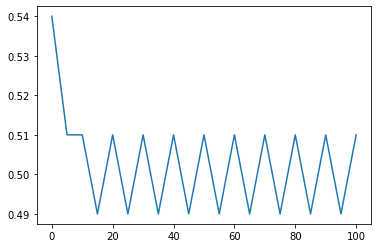

In [29]:
plt.plot(
    list(map(itemgetter(0), density_strategy.measurements)),
    list(map(itemgetter(1), density_strategy.measurements))
)

## Finding cycles

It is clear that all automata have to cycle eventually.  If the number of cells in the automaton is $N$, there are only $2^N$ distinct configurations, so the maximum length of a cycle must be less than or equal to $2^N$.  However, we can compute the distribution of cycle lenghts over the rules.

To detect the cycles, we can implement a strategy that will halt the evolution as soon as a cycle is detected.

In [30]:
class CycleStrategy(EvolutionStrategy):
    
    _history: list
    _cycle_length: int = None
    
    def __init__(self):
        self._history = []

    def apply(self, automaton):
        self._history.append(automaton)
        pos = self._history.index(automaton)
        if pos < len(self._history) - 1:
            self._cycle_length = len(self._history) - pos - 1
            return False
        else:
            return True
            
    @property
    def cycle(self):
        if self._cycle_length is not None:
            return len(self._history) - self._cycle_length - 1, self._cycle_length
        else:
            return len(self._history), self._cycle_length

In [56]:
automaton = random.choices((0, 1), k=10)

In [57]:
automaton

[1, 0, 1, 0, 1, 0, 1, 0, 1, 1]

In [58]:
runner = AutomatonRunner(47)

In [59]:
cycle_strategy = CycleStrategy()

In [60]:
runner.evolve(automaton, 100, cycle_strategy)

In [61]:
cycle_strategy.cycle

(1, 10)

In [62]:
cycle_strategy._history

[[1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 0]]

Just to make sure we define a function that verifies the result.  The generations prior to the start index should not occur in the history, the one at the start index should be equal to the last generation in the history.  Finally, none of the other generations should occur more than once.

In [65]:
def verify_cycle_strategy(strategy, result):
    start_idx, cycle_length = result
    for idx, automaton in enumerate(strategy._history[:-1]):
        if idx == start_idx:
            assert automaton == strategy._history[-1]
        else:
            assert automaton not in strategy._history[idx + 1:]    

In [66]:
verify_cycle_strategy(cycle_strategy, cycle_strategy.cycle)

To illustrate (and further check), compute the cycles for each of the 256 rules and plot them.

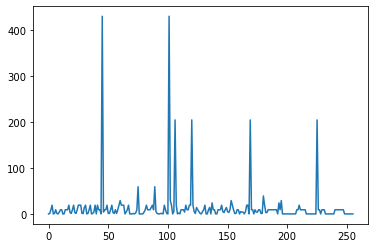

In [67]:
rule_nrs = list(range(256))
cycle_lengths = []
random.seed(1234)
automaton = random.choices((0, 1), k=10)
for rule_nr in rule_nrs:
    runner = AutomatonRunner(rule_nr)
    cycle_strategy = CycleStrategy()
    runner.evolve(automaton, 2**len(automaton), cycle_strategy)
    result = cycle_strategy.cycle
    verify_cycle_strategy(cycle_strategy, result)
    cycle_lengths.append(result[1])
plt.plot(rule_nrs, cycle_lengths)

## Combining strategies

It is very easy to compbine multiple strategies by implementing a... strategy for that purpose.

In [42]:
class MultiStrategy(EvolutionStrategy):
    
    _strategies: tuple
    
    def __init__(self, *strategies):
        self._strategies = strategies
        
    def apply(self, automaton):
        return all(map(lambda s: s.apply(automaton), self._strategies))
    
    @property
    def strategies(self):
        return self._strategies

As a trivial example, we combine the `PlotStrategy` and the `CycleFinderStrategy`.

In [46]:
automaton = random.choices((0, 1), k=10)

In [47]:
runner = AutomatonRunner(47)

In [48]:
strategy = MultiStrategy(PlotStrategy(), CycleStrategy())

In [49]:
runner.evolve(automaton, 100, strategy)

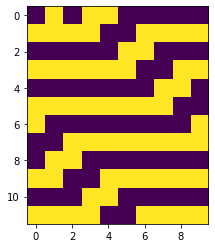

In [50]:
strategy.strategies[0].plot()

In [51]:
strategy.strategies[1].cycle

(1, 10)